### Spracovanie vyskumnych udajov
Predpokladajme, ze mame nasledujucu vyskumnu otazku (RQ):

Ma typ vybranej strategie investora kryptomien podiel na profite investicii do vybranych kryptomien v bear markete?

**Hypoteza**

Formulujeme nulovu a alternativnu hypotezu:

H0: Neexistuje rozdiel v tom ci ludia investuju radsej v bear markete alebo bull markete do vybramych kryptomien.

H1: Existuje rozdiel vo vybere strategie v investovani do vybranych kryptomien.

**Premenne**

Existuje jedna nezavisla premenna feargreed index, je nominalna (kategorická) s 5 urovnami extreme fear, fear, neutral, greed, extreme greed.
Existuje zavisla premenna je typu vyber investicnej strategie.

**Dizajn**

Jeden investor nemoze investovat do viacerich vybranych kryptomien naraz vo vybranom casovom okne, taktiez nemoze pouzit rozne investicne strategie.

**Postup**

Do vybranej studie som zaradili 3 kryptomeny Bitcoin(BTC), Ethereum(ETH), Cosmos(Atom). Data boli zozbierane z burzy Binance v 1 dnovych intervaloch od '2021-11-26' do '2022-11-26' v pare so stable coinom BUSD, v dalsom priebehu som data predspracoval, vykonal korelacie (pearson, kendall,spearman) a nasledne vykonal na type vybranej strategie nakupu a drzania vybranej kryptomeny alebo rozhodovanim s pomocou fear greed indexu.

**Vysledky**

Zozbierane udaje su v suboroch:  
BTC_BUSD_Binance_hour_2022-11-26  
 ETH_BUSD_Binance_hour_2022-11-26  
 ATOM_BUSD_Binance_hour_2022-11-26

**Imports**

In [1]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone, timedelta
import calendar

**Scrapovanie dat z Binance api**

In [2]:
def get_klines_iter(symbol, interval, start, end = None, limit=1000):

    df = pd.DataFrame()

    if start is None:
        print('start time must not be None')
        return
    start = calendar.timegm(datetime.fromisoformat(start).timetuple()) * 1000

    if end is None:
        dt = datetime.now(timezone.utc)
        utc_time = dt.replace(tzinfo=timezone.utc)
        end = int(utc_time.timestamp()) * 1000
        return
    else:
        end = calendar.timegm(datetime.fromisoformat(end).timetuple()) * 1000
    last_time = None

    while len(df) == 0 or (last_time is not None and last_time < end):
        url = 'https://api.binance.com/api/v3/klines?symbol=' + \
              symbol + '&interval=' + interval + '&limit=1000'
        if(len(df) == 0):
            url += '&startTime=' + str(start)
        else:
            url += '&startTime=' + str(last_time)

        url += '&endTime=' + str(end)
        df2 = pd.read_json(url)
        df2.columns = ['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime',
                       'Quote asset volume', 'Number of trades', 'Taker by base', 'Taker buy quote', 'Ignore']
        dftmp = pd.DataFrame()
        dftmp = pd.concat([df2, dftmp], axis=0, ignore_index=True, keys=None)

        dftmp.Opentime = pd.to_datetime(dftmp.Opentime, unit='ms')
        dftmp['datetime'] = dftmp.Opentime.dt.strftime("%Y-%m-%d")
        dftmp = dftmp.drop(['Quote asset volume', 'Closetime', 'Opentime',
                      'Number of trades', 'Taker by base', 'Taker buy quote', 'Ignore'], axis=1)
        column_names = ["datetime", "Open", "High", "Low", "Close", "Volume"]
        dftmp.reset_index(drop=True, inplace=True)
        dftmp = dftmp.reindex(columns=column_names)
        string_dt = str(dftmp['datetime'][len(dftmp) - 1])
        utc_last_time = datetime.strptime(string_dt,"%Y-%m-%d")
        last_time = (utc_last_time - datetime(1970, 1, 1)) // timedelta(milliseconds=1)
        df = pd.concat([df, dftmp], axis=0, ignore_index=True, keys=None)
    df.to_csv(symbol[:-4] + '_BUSD_Binance_hour_2022-11-26.csv', sep=',', index=False)
    print(df)
    
get_klines_iter('BTCBUSD', '1d', '2021-11-26', '2022-11-26')
get_klines_iter('ETHBUSD', '1d', '2021-11-26', '2022-11-26')
get_klines_iter('ATOMBUSD', '1d', '2021-11-26', '2022-11-26')


       datetime      Open      High       Low     Close        Volume
0    2021-11-26  58999.99  59191.99  53511.00  53759.97   17773.69862
1    2021-11-27  53756.29  55304.81  53644.88  54762.33    7758.23976
2    2021-11-28  54762.32  57471.01  53310.00  57317.97    9229.56020
3    2021-11-29  57317.12  58900.61  56728.28  57826.71    8748.92499
4    2021-11-30  57826.72  59219.27  55929.00  56981.05   13182.52246
..          ...       ...       ...       ...       ...           ...
361  2022-11-22  15761.55  16294.00  15598.60  16208.44  140753.21958
362  2022-11-23  16208.46  16687.00  16141.06  16585.14  135884.51283
363  2022-11-24  16587.51  16798.00  16449.62  16586.95  109731.40677
364  2022-11-25  16587.58  16620.00  16332.52  16512.68  101808.76420
365  2022-11-26  16512.02  16692.53  16375.00  16448.92   89899.09197

[366 rows x 6 columns]
       datetime     Open     High      Low    Close       Volume
0    2021-11-26  4527.07  4553.65  3916.18  4044.85  228386.7928
1    2

**Spracovanie dat**

In [3]:
def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)
def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

In [4]:
df_btc = read_dataset(get_filename('BTC', 'BUSD', 'Binance', 'hour', '2022-11-26'))
df_atom = read_dataset(get_filename('ATOM', 'BUSD', 'Binance', 'hour', '2022-11-26'))
df_eth = read_dataset(get_filename('ETH', 'BUSD', 'Binance', 'hour', '2022-11-26'))
df_btc.head()

Reading data from BTC_BUSD_Binance_hour_2022-11-26.csv
(366, 5)
Reading data from ATOM_BUSD_Binance_hour_2022-11-26.csv
(366, 5)
Reading data from ETH_BUSD_Binance_hour_2022-11-26.csv
(366, 5)


,Open,High,Low,Close,Volume
datetime,,,,,
2021-11-26,58999.99,59191.99,53511.00,53759.97,17773.69862
2021-11-27,53756.29,55304.81,53644.88,54762.33,7758.23976
2021-11-28,54762.32,57471.01,53310.00,57317.97,9229.56020
2021-11-29,57317.12,58900.61,56728.28,57826.71,8748.92499
2021-11-30,57826.72,59219.27,55929.00,56981.05,13182.52246


In [5]:
df_eth.head()

,Open,High,Low,Close,Volume
datetime,,,,,
2021-11-26,4527.07,4553.65,3916.18,4044.85,228386.7928
2021-11-27,4043.67,4185.74,4031.83,4098.02,86395.5469
2021-11-28,4097.88,4301.55,3965.49,4298.14,108556.1541
2021-11-29,4298.15,4463.00,4281.22,4448.42,109285.6020
2021-11-30,4448.41,4756.80,4349.83,4631.81,205269.7430


In [6]:
df_atom.head()

,Open,High,Low,Close,Volume
datetime,,,,,
2021-11-26,29.78,30.30,25.18,27.09,563322.29
2021-11-27,27.09,28.07,26.48,26.75,213568.30
2021-11-28,26.74,27.62,24.72,27.41,266224.59
2021-11-29,27.39,28.45,26.75,28.14,250677.28
2021-11-30,28.11,29.37,27.00,27.50,353756.72


In [7]:
df_btc = df_btc.loc[~df_btc.index.duplicated(), :]
df_eth = df_eth.loc[~df_eth.index.duplicated(), :]
df_atom = df_atom.loc[~df_atom.index.duplicated(), :]

**Extrakcia uzatvaracich cien za dane obdobie**

In [8]:
df = pd.DataFrame({'BTC': df_btc.Close,
                   'ETH': df_eth.Close,
                   'ATOM': df_atom.Close})
df.head()

,BTC,ETH,ATOM
datetime,,,
2021-11-26,53759.97,4044.85,27.09
2021-11-27,54762.33,4098.02,26.75
2021-11-28,57317.97,4298.14,27.41
2021-11-29,57826.71,4448.42,28.14
2021-11-30,56981.05,4631.81,27.50


**Za 1 rok vybrane tri kryptomeny velmi kolisali, co nasvadcuje tomu, ze sme v bear markete (boli volatilne voci udalostiam vo svete) pozri udaje nizsie. Pre kazdu mincu som spocital pocet vyskytov a vypocítal som priemer, standardnu odchylku, minimum, kvartaly a maximalnu uzatvaraciu cenu.**

In [9]:
df.describe()

,BTC,ETH,ATOM
count,366.000000,366.000000,366.000000
mean,31433.772650,2264.769235,18.721803
std,11406.470373,952.078409,9.441611
min,15761.540000,993.570000,6.070000
25%,20352.762500,1428.412500,10.751750
50%,29648.130000,1940.630000,13.946000
75%,41652.452500,3000.597500,27.285000
max,57826.710000,4631.810000,43.660000


**Na box grafe nizsie pozorujeme, ze uzatvaracia cena Atom sa za posledny 1 rok pohybovala vacsinu casu medzi 10 a 27 USD.**

Text(0.5, 0, 'Cena $')

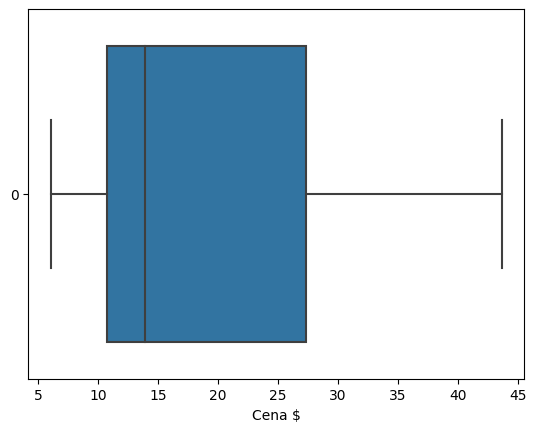

In [10]:
ax = sns.boxplot(data=df['ATOM'], orient="h")
plt.xlabel('Cena $')

**Histogram zobrazuje pocet hodin, v ktorych si ATOM drzal urcitu uzatvaraciu cenu. Uzatvaracia cena Atom nebola pocas polovice vybranych hodin vyssia ako 20 USD. Modra prerusovana ciara (median) ukazuje, ze polovicu času boli uzatvaracie ceny pod 14 USD.**

Text(0.5, 0, 'Cena $')

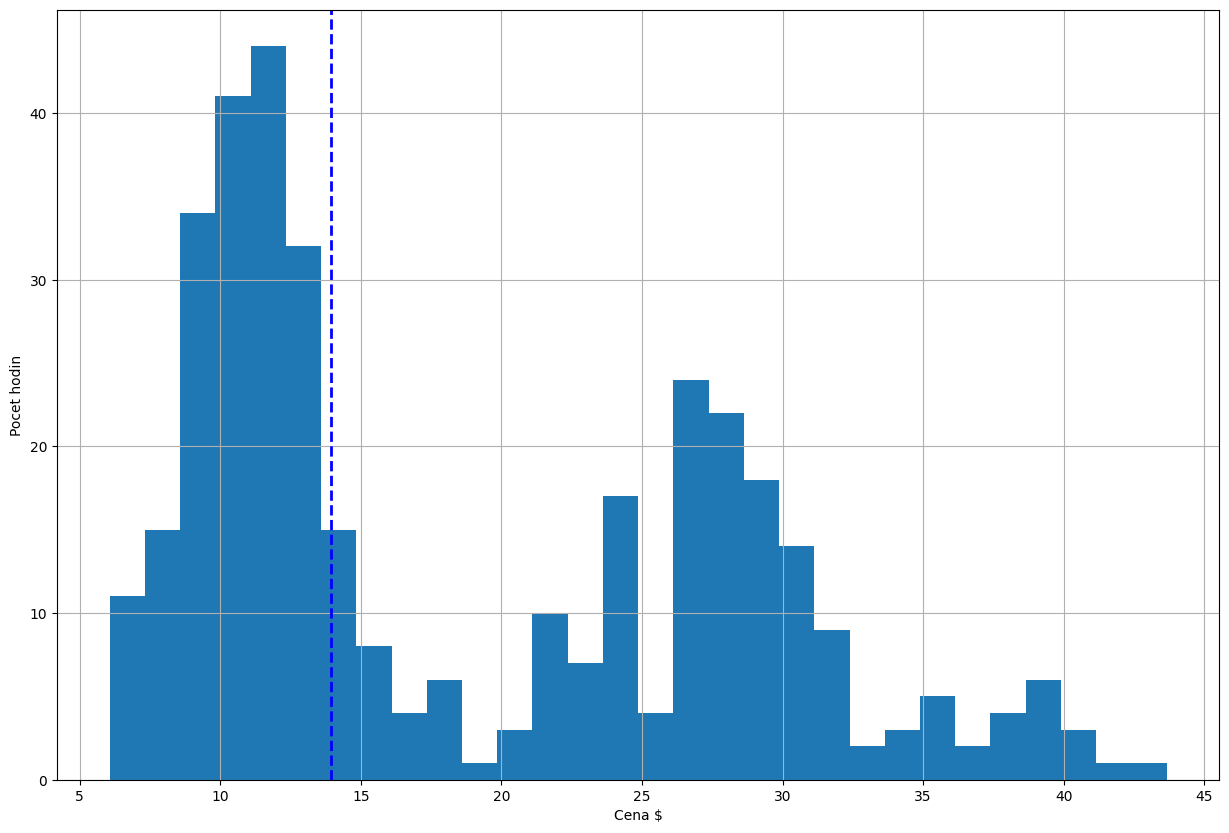

In [11]:
df['ATOM'].hist(bins=30, figsize=(15,10)).axvline(df['ATOM'].median(), color='b', linestyle='dashed', linewidth=2)
plt.ylabel('Pocet hodin')
plt.xlabel('Cena $')

**Tento graf zobrazuje uzatvaracie ceny, neprikladajme mu velky vyznam, pretoze uzatvaracie ceny BTC su ovela vyssie ako ceny ETH alebo ATOM.**

Text(0.5, 0, 'Cas')

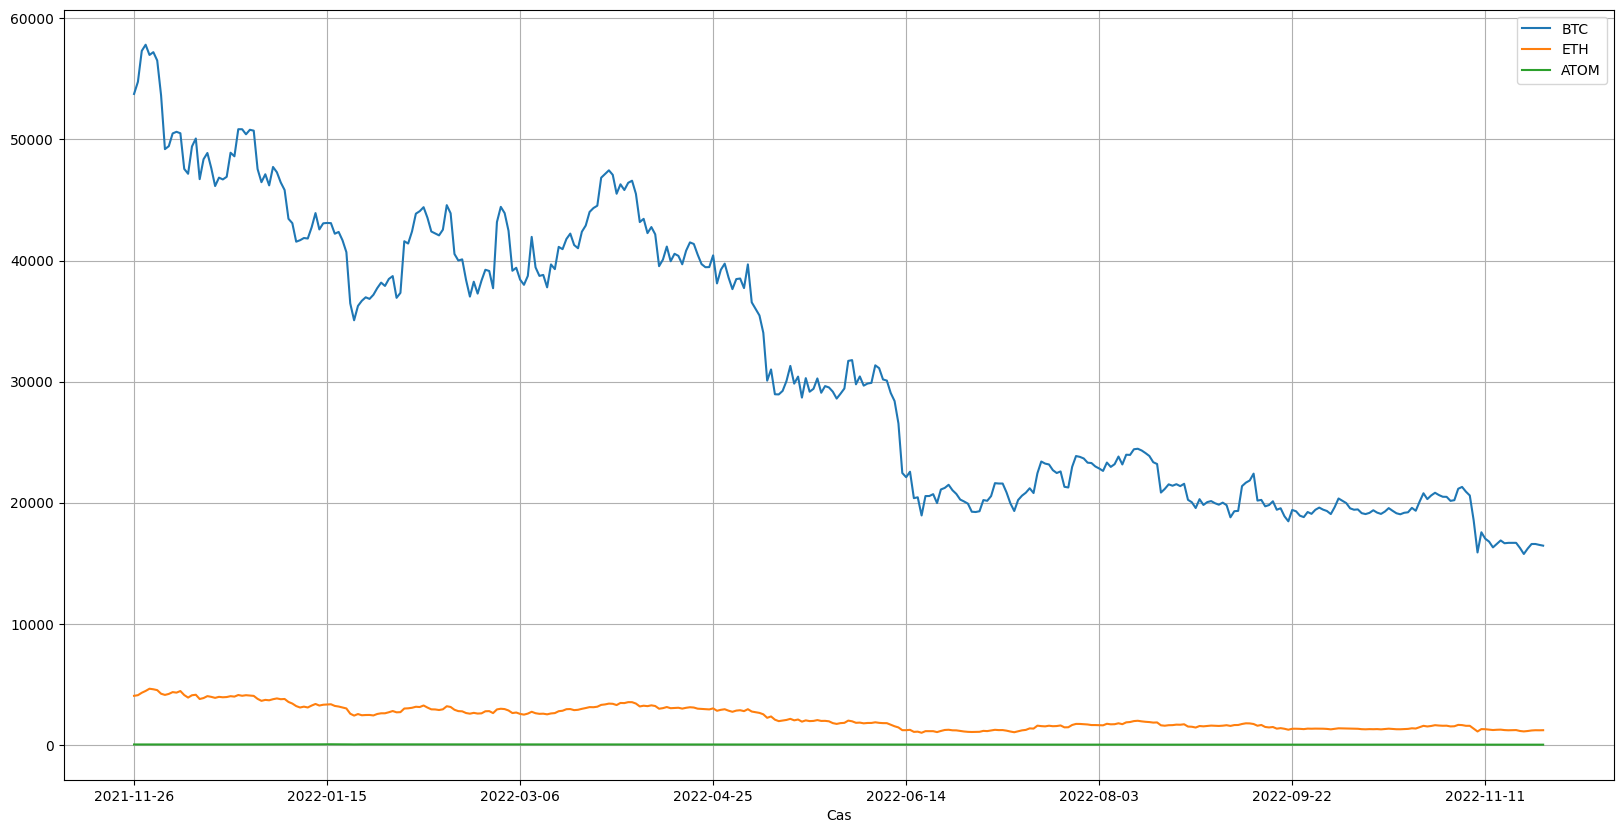

In [12]:
df.plot(grid=True, figsize=(20, 10))
plt.xlabel('Cas')

**Dalej sme vypocitali Pearson, Spearman, Kendall korelaciu medzi uzatváracími cenami BTC, ETH a ATOM. Pearsonova korelácia je mierou lineárnej korelácie medzi dvoma premennými X a Y. Má hodnotu od +1 do -1, kde 1 je celková pozitívna lineárna korelácia, 0 je žiadna lineárna korelácia a -1 je celková negatívna lineárna korelácia.**

**Treba podoknut ze uzatvaracie ceny nie su normalizovane.**

**BTC, ETH a ATOM za posledný rok korelovali medzi sebou, to znamena, ze ked sa uzatvaracia cena BTC zvysila, ETH a ATOM ju nasledovali.**

**Pre Atom a BTC sme dosiahli Pearsonov korelacny koeficient 0,8383.**

**Pearson corr**

C:\Users\danie\AppData\Local\Temp\ipykernel_5136\2172115217.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot: >

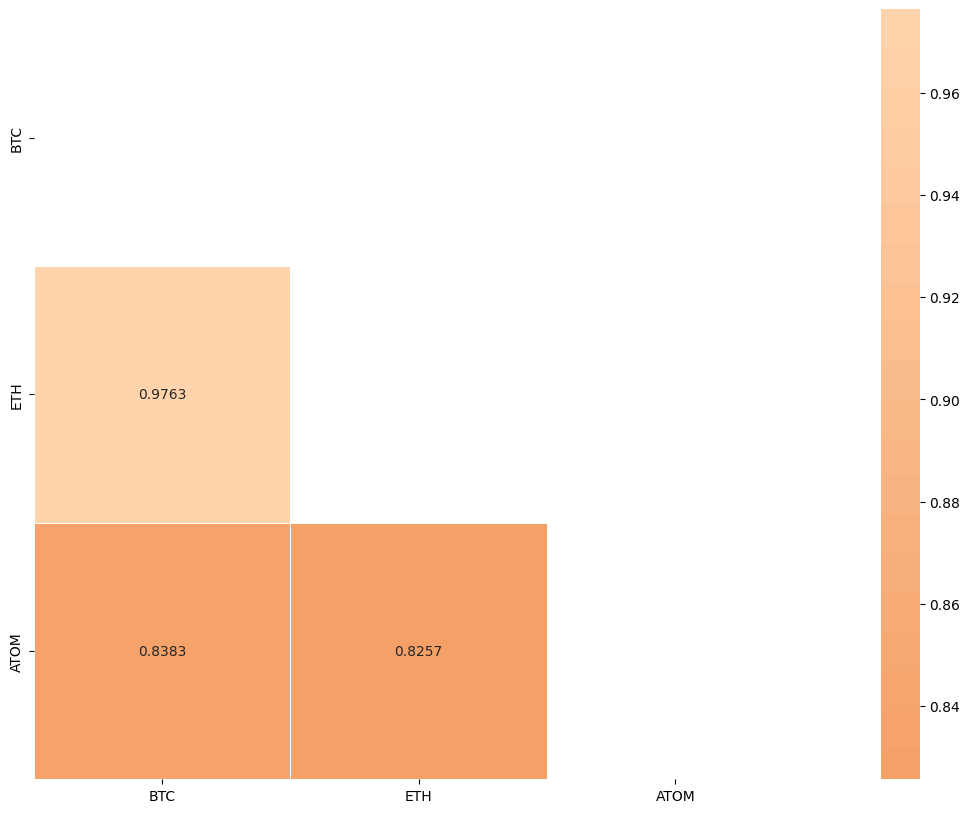

In [13]:
# Compute the correlation matrix
corr = df.corr(method = 'pearson')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

**Spearman corr**

C:\Users\danie\AppData\Local\Temp\ipykernel_5136\281601467.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot: >

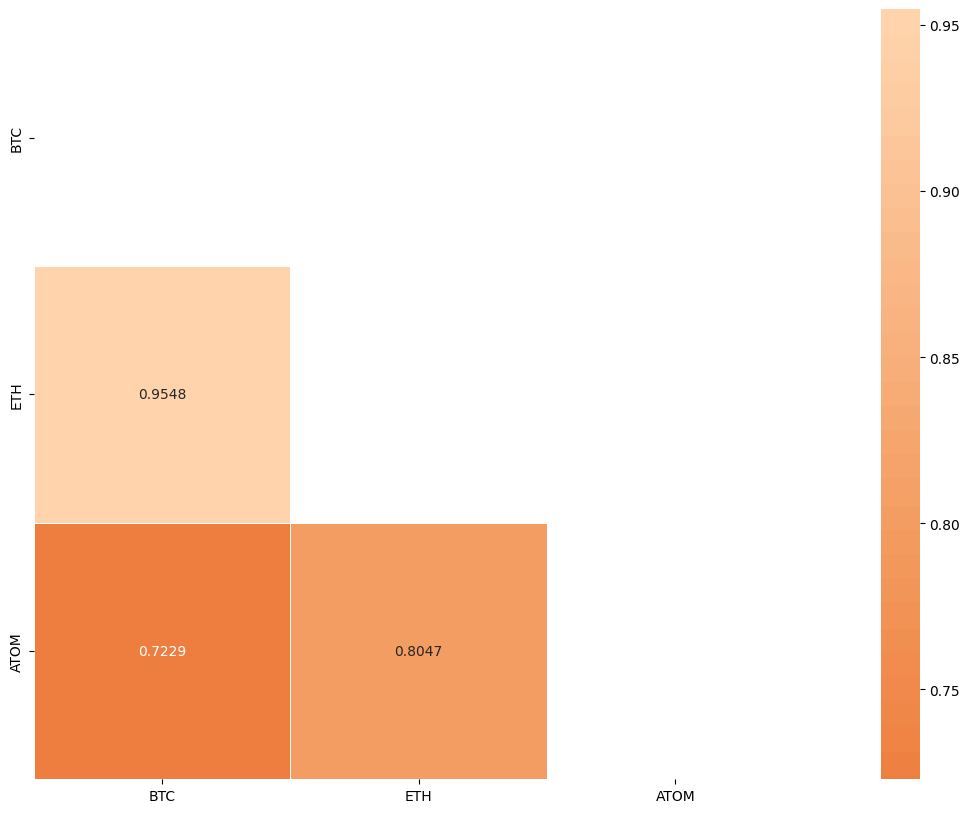

In [14]:
# Compute the correlation matrix
corr = df.corr(method = 'spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

**Kendall corr**

C:\Users\danie\AppData\Local\Temp\ipykernel_5136\3107473584.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot: >

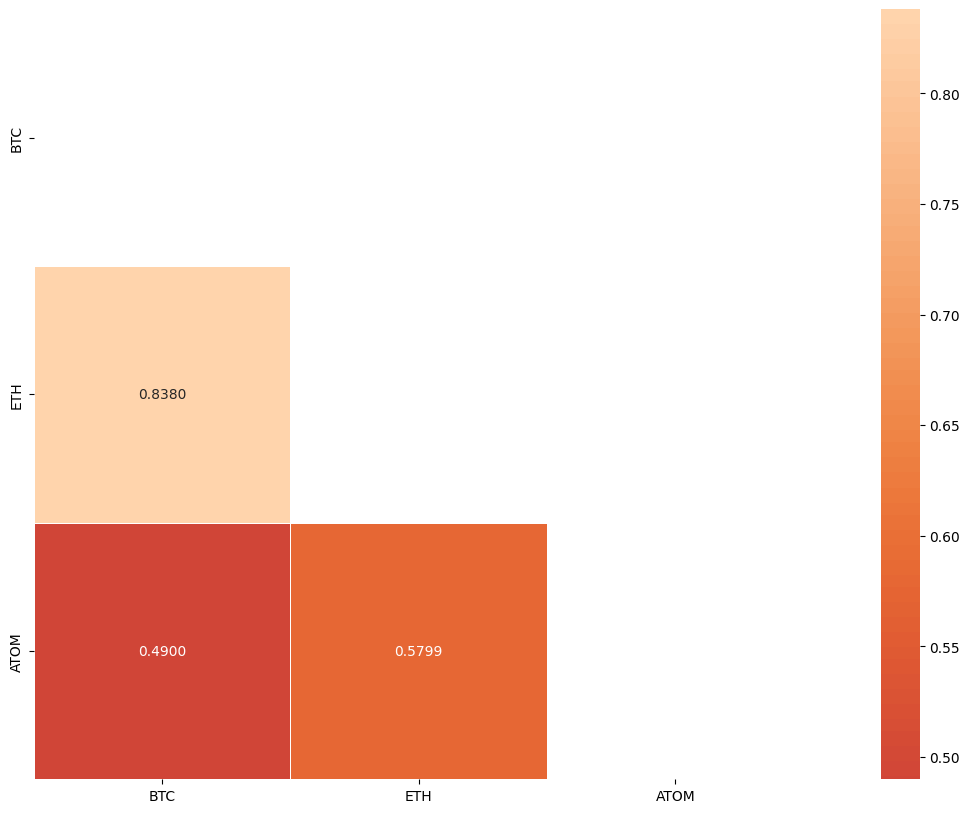

In [15]:
# Compute the correlation matrix
corr = df.corr(method = 'kendall')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

**Prva strategia buy and hodl.**

**Buy and hodl je passvna investicna strategia, pri ktorej investor kupuje kryptomenu a drzi ju dlhe obdobie bez ohladu na vykyvy na trhu.**
**Analyzujme vynosy pomocou zvolenej stratégie za posledny 1 rok a vypocitame percentualny vynos.**

In [16]:
df_return = df.apply(lambda x: x / x[0])
df_return.head()

,BTC,ETH,ATOM
datetime,,,
2021-11-26,1.000000,1.000000,1.000000
2021-11-27,1.018645,1.013145,0.987449
2021-11-28,1.066183,1.062620,1.011812
2021-11-29,1.075646,1.099774,1.038760
2021-11-30,1.059916,1.145113,1.015135


**Vidime, ze investor buy and hodl strategie v kryptomene ATOM bol najviac profitujuci zaciatkom januara tohto roka.**

Text(0.5, 0, 'Cas')

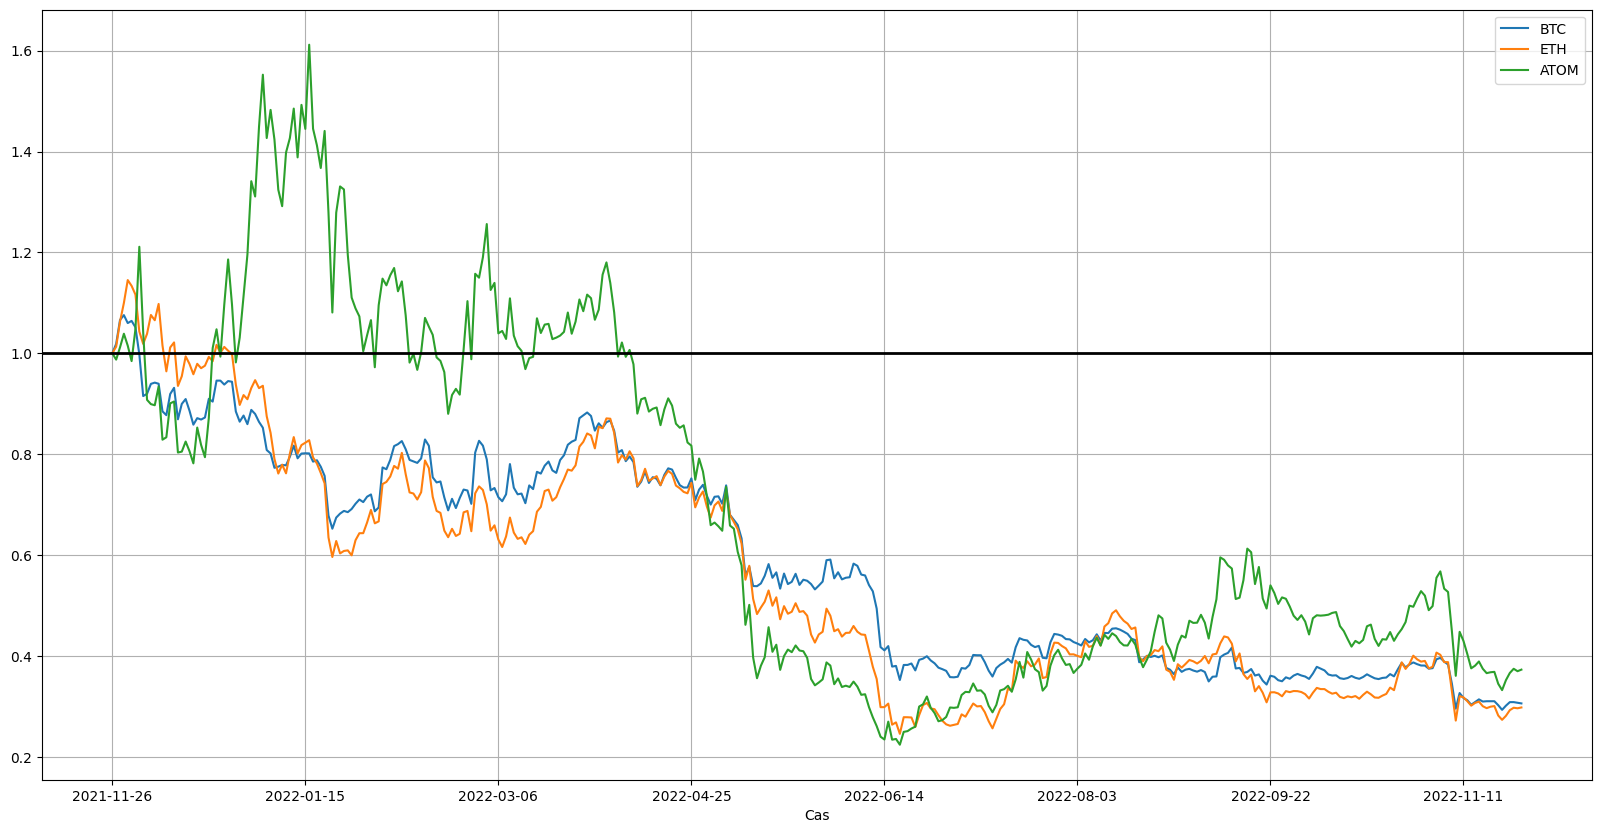

In [17]:
df_return.plot(grid=True, figsize=(20, 10)).axhline(y = 1, color = "black", lw = 2)
plt.xlabel('Cas')

**Mnozstvo tokenov, ktore si mohol dovolit investor na zaciatku investicie pred 1 rokom.**

,BTC,ETH,ATOM
datetime,,,
2021-11-26,0.018601,0.247228,36.91399


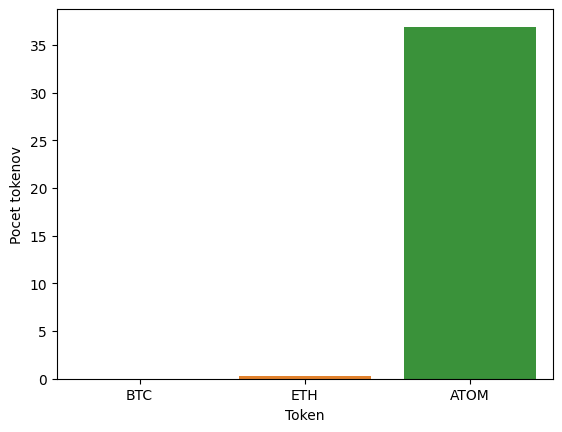

In [18]:
budget = 1000 #BUSD
df_coins = budget/df.head(1)

ax = sns.barplot(data=df_coins)
plt.ylabel('Pocet tokenov')
plt.xlabel('Token')
df_coins

**Vypocitane jednotlive profity investorov.**

In [19]:
current_price = df['ATOM'][1] * df_coins['ATOM'][0]
print('Money invested in the begining to ATOM:',budget)
print('Current profit now in $:',current_price)

Money invested in the begining to ATOM: 1000
Current profit now in $: 987.4492432631966


In [20]:
current_price = df['BTC'][1] * df_coins['BTC'][0]
print('Money invested in the begining to BTC:', budget)
print('Current profit now in $:',current_price)

Money invested in the begining to BTC: 1000
Current profit now in $: 1018.6450996903458


In [21]:
current_price = df['ETH'][1] * df_coins['ETH'][0]
print('Money invested in the begining to ETH:', budget)
print('Current profit now in $:',current_price)


Money invested in the begining to ETH: 1000
Current profit now in $: 1013.1451104490897


**Druha investicna strategia fear greed index.**

**Spracovanie dat fear greed index z api.alternative.**

In [22]:
r = requests.get('https://api.alternative.me/fng/?limit=0')

**Spracovanie dat**

In [23]:
##print data
#r.json()

In [24]:
df3 = pd.DataFrame(r.json()['data'])

In [25]:
df3
df3 = df3.drop(['time_until_update'], axis=1)

In [26]:
df3.value = df3.value.astype(int)
df3.timestamp = pd.to_datetime(df3.timestamp, unit= 's')
df3.set_index('timestamp',inplace=True)
df3

,value,value_classification
timestamp,,
2022-11-29,26,Fear
2022-11-28,28,Fear
2022-11-27,26,Fear
2022-11-26,22,Extreme Fear
2022-11-25,20,Extreme Fear
...,...,...
2018-02-05,11,Extreme Fear
2018-02-04,24,Extreme Fear
2018-02-03,40,Fear


**Graf fear greed indexu od roku 2018.**

Text(0.5, 0, 'Cas')

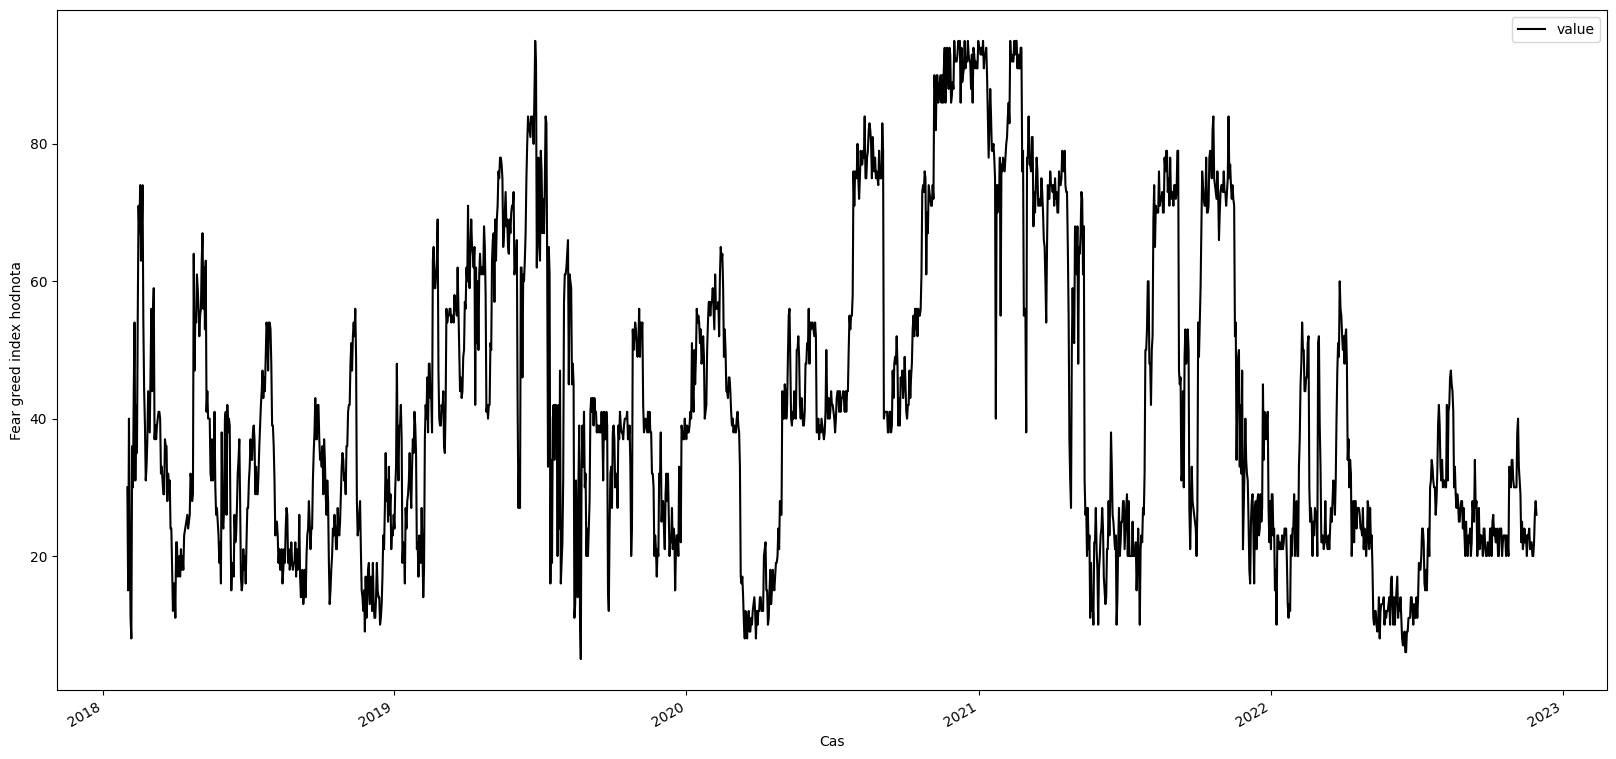

In [27]:
df3.plot(figsize=(20,10),color="black")
plt.ylabel('Fear greed index hodnota')
plt.xlabel('Cas')

In [28]:
df3 = df3[::-1]

In [29]:
df3

,value,value_classification
timestamp,,
2018-02-01,30,Fear
2018-02-02,15,Extreme Fear
2018-02-03,40,Fear
2018-02-04,24,Extreme Fear
2018-02-05,11,Extreme Fear
...,...,...
2022-11-25,20,Extreme Fear
2022-11-26,22,Extreme Fear
2022-11-27,26,Fear


**Graf fear greed indexu za nase vybrane casove obdobie.**

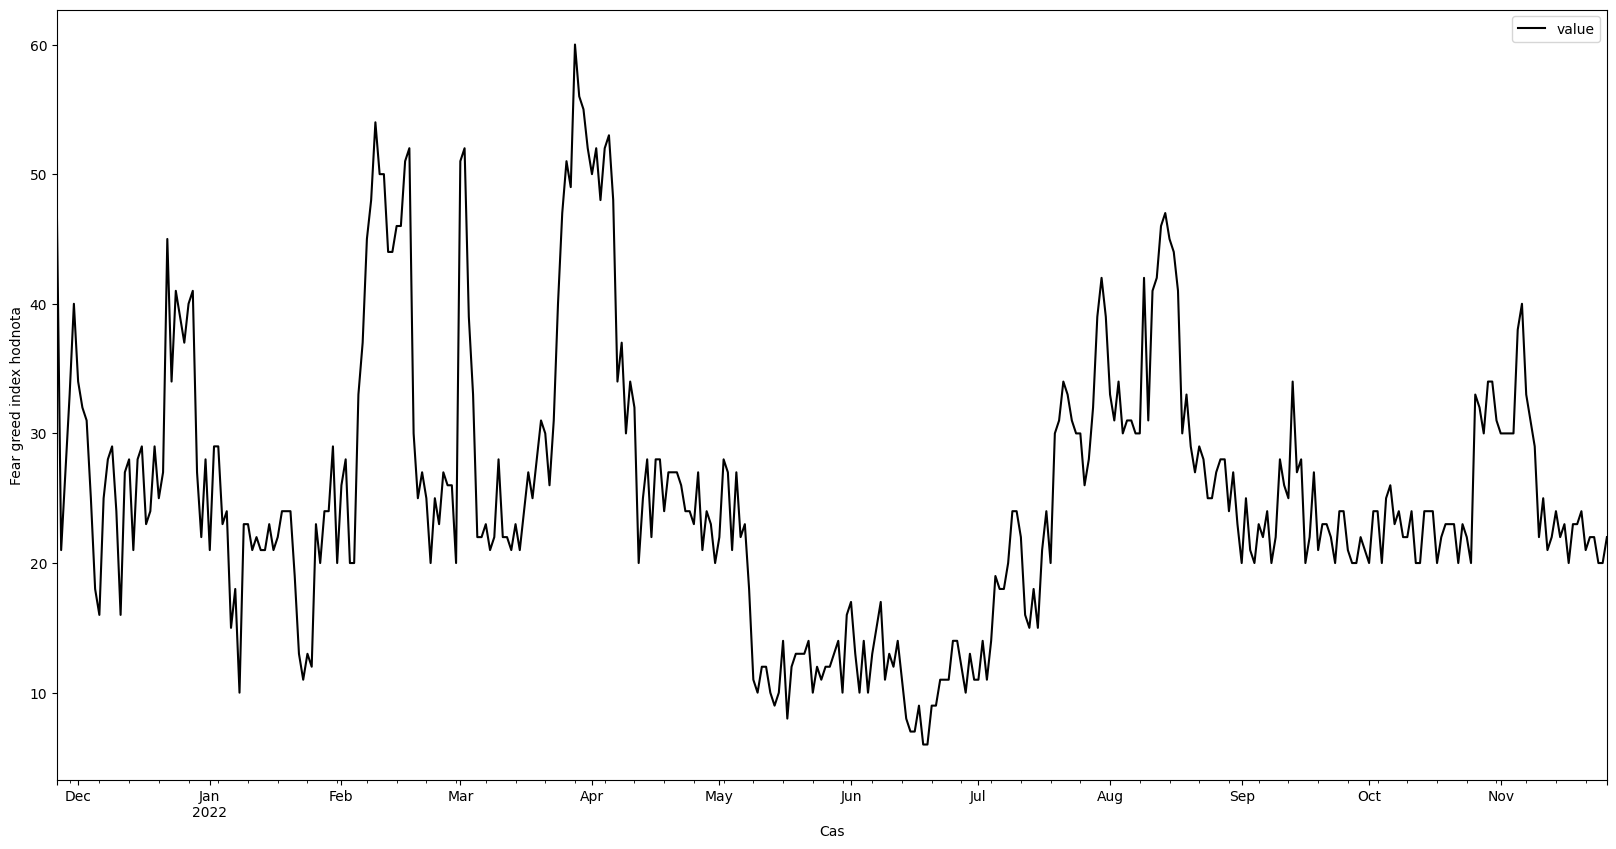

In [30]:
df3 = df3.loc['2021-11-26':'2022-11-26']
df3.plot(y='value',figsize=(20,10), color='black')
plt.ylabel('Fear greed index hodnota')
plt.xlabel('Cas')
plt.show()

In [31]:
df_btc.index.name = 'timestamp'
df_btc

,Open,High,Low,Close,Volume
timestamp,,,,,
2021-11-26,58999.99,59191.99,53511.00,53759.97,17773.69862
2021-11-27,53756.29,55304.81,53644.88,54762.33,7758.23976
2021-11-28,54762.32,57471.01,53310.00,57317.97,9229.56020
2021-11-29,57317.12,58900.61,56728.28,57826.71,8748.92499
2021-11-30,57826.72,59219.27,55929.00,56981.05,13182.52246
...,...,...,...,...,...
2022-11-22,15761.55,16294.00,15598.60,16208.44,140753.21958
2022-11-23,16208.46,16687.00,16141.06,16585.14,135884.51283
2022-11-24,16587.51,16798.00,16449.62,16586.95,109731.40677


In [32]:
df_eth.index.name = 'timestamp'
df_eth

,Open,High,Low,Close,Volume
timestamp,,,,,
2021-11-26,4527.07,4553.65,3916.18,4044.85,228386.7928
2021-11-27,4043.67,4185.74,4031.83,4098.02,86395.5469
2021-11-28,4097.88,4301.55,3965.49,4298.14,108556.1541
2021-11-29,4298.15,4463.00,4281.22,4448.42,109285.6020
2021-11-30,4448.41,4756.80,4349.83,4631.81,205269.7430
...,...,...,...,...,...
2022-11-22,1106.11,1145.80,1073.84,1138.10,444280.5798
2022-11-23,1138.25,1189.43,1126.57,1183.31,377272.3006
2022-11-24,1183.31,1216.88,1180.11,1202.82,282792.2207


In [33]:
df_atom.index.name = 'timestamp'
df_atom

,Open,High,Low,Close,Volume
timestamp,,,,,
2021-11-26,29.780,30.300,25.180,27.090,563322.29
2021-11-27,27.090,28.070,26.480,26.750,213568.30
2021-11-28,26.740,27.620,24.720,27.410,266224.59
2021-11-29,27.390,28.450,26.750,28.140,250677.28
2021-11-30,28.110,29.370,27.000,27.500,353756.72
...,...,...,...,...,...
2022-11-22,9.006,9.554,8.720,9.538,756021.71
2022-11-23,9.538,9.966,9.522,9.923,691228.17
2022-11-24,9.924,10.226,9.776,10.148,512871.43


**Fear greed index pre ATOM investora.**

In [34]:
df_atom = df_atom.reset_index()
df_atom
df_atom['timestamp']=df_atom['timestamp'].astype('datetime64[ns]')


In [35]:
new_df_atom = df3.merge(df_atom, on=['timestamp'])


In [36]:
new_df_atom = new_df_atom.set_index('timestamp')

In [37]:
new_df_atom

,value,value_classification,Open,High,Low,Close,Volume
timestamp,,,,,,,
2021-11-26,47,Neutral,29.780,30.300,25.180,27.090,563322.29
2021-11-27,21,Extreme Fear,27.090,28.070,26.480,26.750,213568.30
2021-11-28,27,Fear,26.740,27.620,24.720,27.410,266224.59
2021-11-29,33,Fear,27.390,28.450,26.750,28.140,250677.28
2021-11-30,40,Fear,28.110,29.370,27.000,27.500,353756.72
...,...,...,...,...,...,...,...
2022-11-22,22,Extreme Fear,9.006,9.554,8.720,9.538,756021.71
2022-11-23,22,Extreme Fear,9.538,9.966,9.522,9.923,691228.17
2022-11-24,20,Extreme Fear,9.924,10.226,9.776,10.148,512871.43


**Novy stlpec, na ktory aplikujeme pct funkciu, ktory obsahuje denne zmeny uzatvaracej ceny.**

In [38]:
new_df_atom['change'] = new_df_atom.Close.pct_change()

In [39]:
new_df_atom

,value,value_classification,Open,High,Low,Close,Volume,change
timestamp,,,,,,,,
2021-11-26,47,Neutral,29.780,30.300,25.180,27.090,563322.29,NaN
2021-11-27,21,Extreme Fear,27.090,28.070,26.480,26.750,213568.30,-0.012551
2021-11-28,27,Fear,26.740,27.620,24.720,27.410,266224.59,0.024673
2021-11-29,33,Fear,27.390,28.450,26.750,28.140,250677.28,0.026633
2021-11-30,40,Fear,28.110,29.370,27.000,27.500,353756.72,-0.022743
...,...,...,...,...,...,...,...,...
2022-11-22,22,Extreme Fear,9.006,9.554,8.720,9.538,756021.71,0.059542
2022-11-23,22,Extreme Fear,9.538,9.966,9.522,9.923,691228.17,0.040365
2022-11-24,20,Extreme Fear,9.924,10.226,9.776,10.148,512871.43,0.022675


**Strategia je, ze kupujeme len ked je fear gread index nad 50 (greed uroven), dve boolean hodnoty 1 ked sme v pozicii a 0 ked nie.**

In [40]:
new_df_atom['position'] = np.where(new_df_atom.value > 50,1,0)

**Zisk nasobime z nasobenia stlpcov pozicie a zmeny uzatvaracej ceny, pretoze ak sme v pozicii tak mame zisk z vybranej kryptomeny, ak nie sme v pozicii tak nemame zisk.**

In [41]:
strategy = new_df_atom.position * new_df_atom.change

**Aplikujeme kumulativny funkciu, ak je ciara "rovna vertikalne, nemeniaca sa", tak v pozicii nie sme.**

Text(0.5, 0, 'Cas')

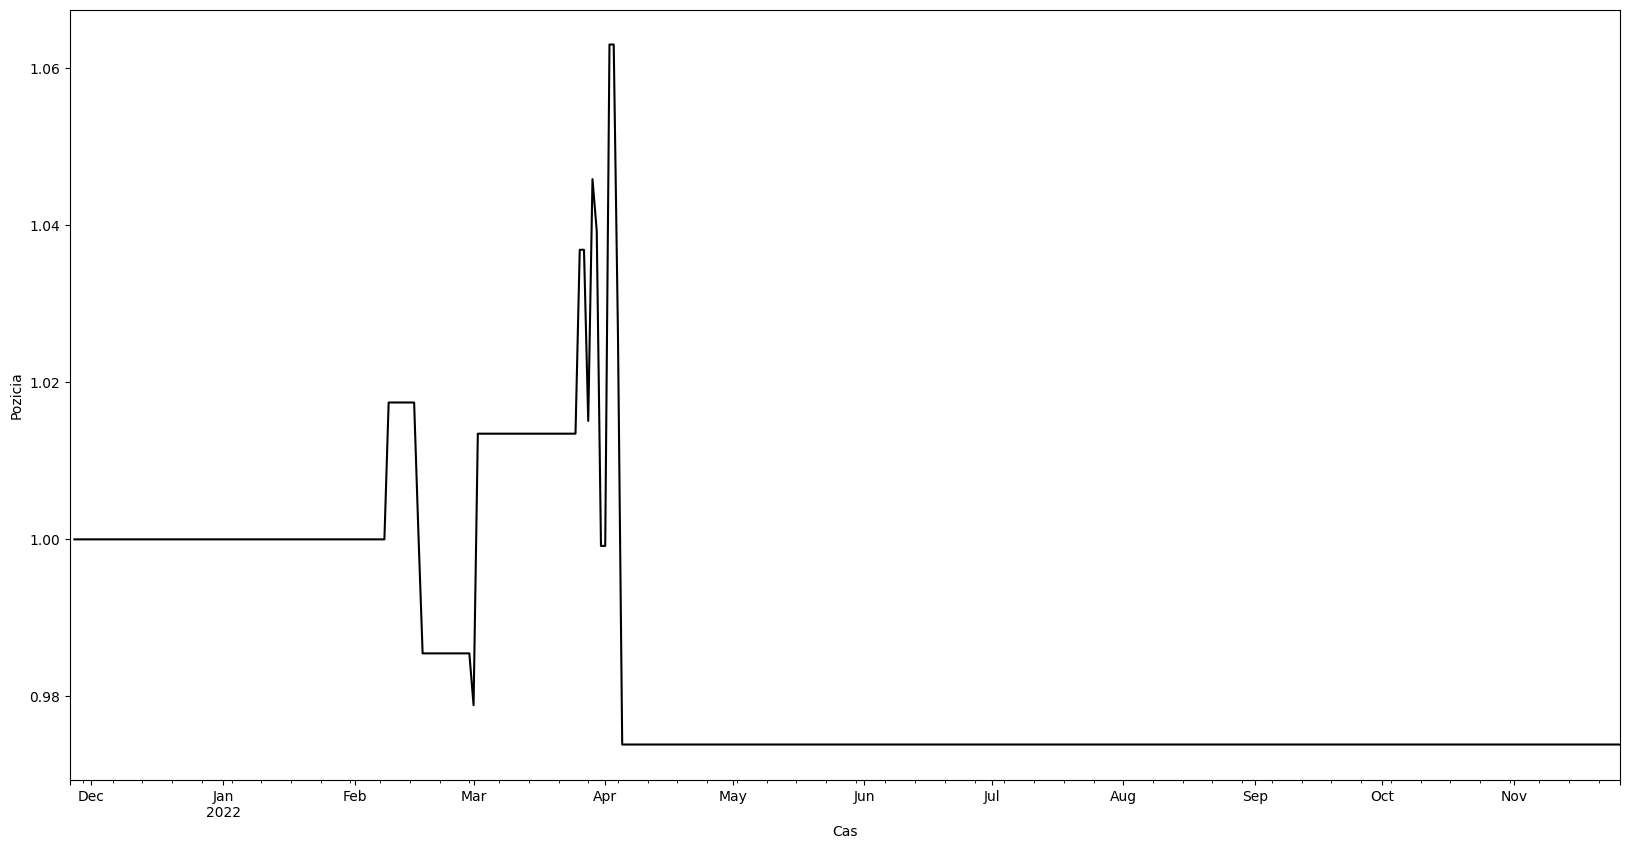

In [42]:
(strategy + 1).cumprod().plot(figsize=(20,10), color ='black')
plt.ylabel('Pozicia')
plt.xlabel('Cas')

**Vidime ze ATOM price action je vo vacsine casu bear marketu riadena fear and greed indexom. Zo zaciatku roka zmena uzatvaracej ceny ATOMu outperformla fear and greed index strategiu.**

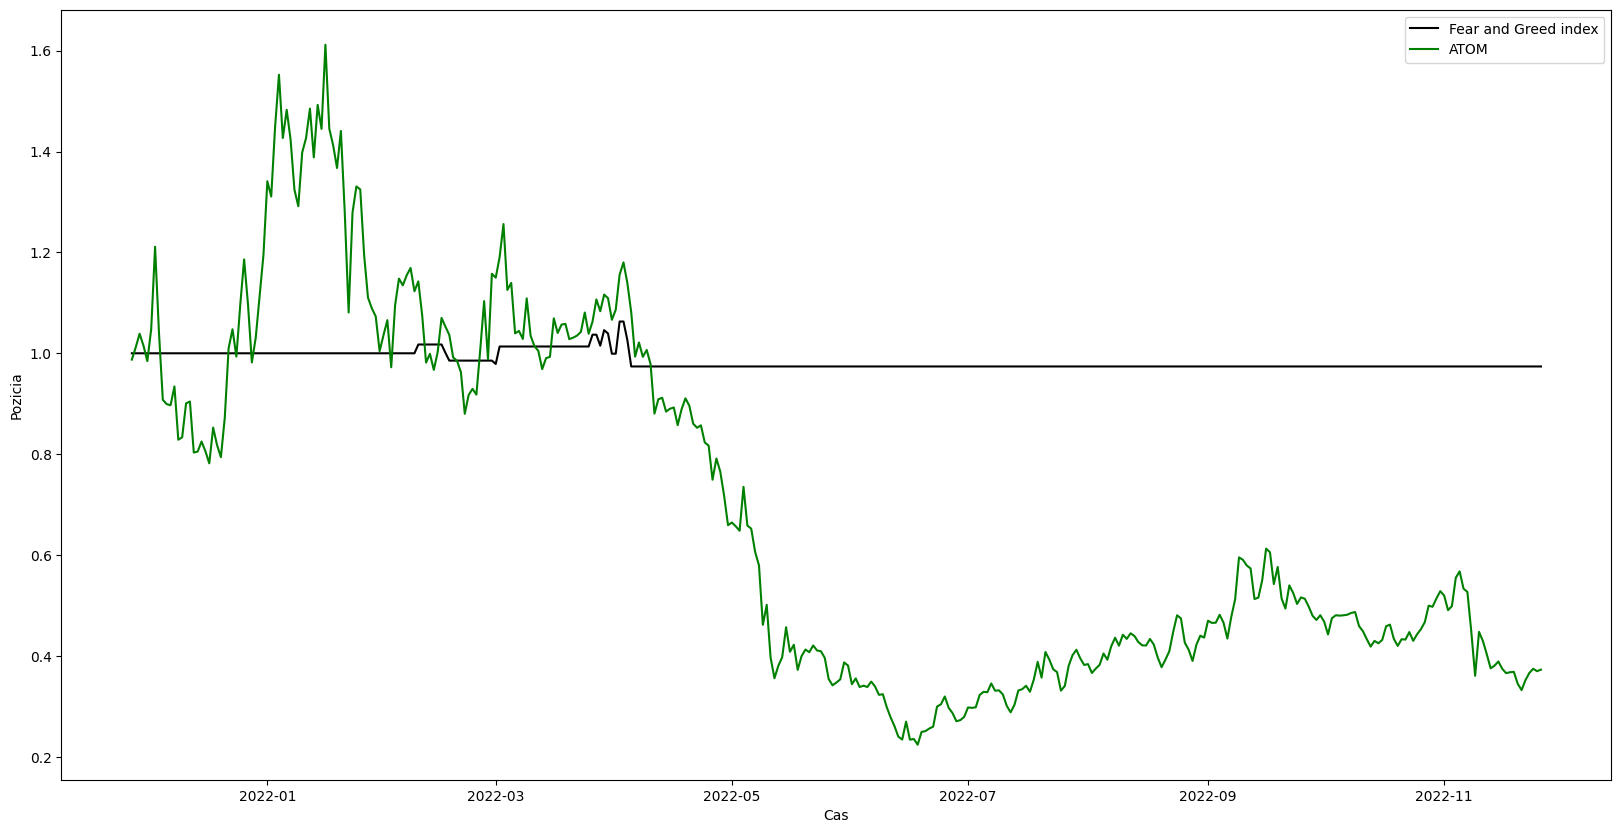

In [43]:
plt.figure(figsize=(20,10))
plt.plot((strategy + 1).cumprod(), label='Fear and Greed index', color = 'black')
plt.plot((new_df_atom.change + 1).cumprod(), label='ATOM', color = 'green')
plt.ylabel('Pozicia')
plt.xlabel('Cas')
plt.legend()

**Fear greed index pre BTC investora.**

In [44]:
df_btc = df_btc.reset_index()
df_btc
df_btc['timestamp']=df_btc['timestamp'].astype('datetime64[ns]')

In [45]:
new_df_btc = df3.merge(df_btc, on=['timestamp'])

In [46]:
new_df_btc = new_df_btc.set_index('timestamp')

In [47]:
new_df_btc

,value,value_classification,Open,High,Low,Close,Volume
timestamp,,,,,,,
2021-11-26,47,Neutral,58999.99,59191.99,53511.00,53759.97,17773.69862
2021-11-27,21,Extreme Fear,53756.29,55304.81,53644.88,54762.33,7758.23976
2021-11-28,27,Fear,54762.32,57471.01,53310.00,57317.97,9229.56020
2021-11-29,33,Fear,57317.12,58900.61,56728.28,57826.71,8748.92499
2021-11-30,40,Fear,57826.72,59219.27,55929.00,56981.05,13182.52246
...,...,...,...,...,...,...,...
2022-11-22,22,Extreme Fear,15761.55,16294.00,15598.60,16208.44,140753.21958
2022-11-23,22,Extreme Fear,16208.46,16687.00,16141.06,16585.14,135884.51283
2022-11-24,20,Extreme Fear,16587.51,16798.00,16449.62,16586.95,109731.40677


In [48]:
new_df_btc['change'] = new_df_btc.Close.pct_change()

In [49]:
new_df_btc

,value,value_classification,Open,High,Low,Close,Volume,change
timestamp,,,,,,,,
2021-11-26,47,Neutral,58999.99,59191.99,53511.00,53759.97,17773.69862,NaN
2021-11-27,21,Extreme Fear,53756.29,55304.81,53644.88,54762.33,7758.23976,0.018645
2021-11-28,27,Fear,54762.32,57471.01,53310.00,57317.97,9229.56020,0.046668
2021-11-29,33,Fear,57317.12,58900.61,56728.28,57826.71,8748.92499,0.008876
2021-11-30,40,Fear,57826.72,59219.27,55929.00,56981.05,13182.52246,-0.014624
...,...,...,...,...,...,...,...,...
2022-11-22,22,Extreme Fear,15761.55,16294.00,15598.60,16208.44,140753.21958,0.028354
2022-11-23,22,Extreme Fear,16208.46,16687.00,16141.06,16585.14,135884.51283,0.023241
2022-11-24,20,Extreme Fear,16587.51,16798.00,16449.62,16586.95,109731.40677,0.000109


In [50]:
new_df_btc['position'] = np.where(new_df_btc.value > 50,1,0)

In [51]:
strategy = new_df_btc.position * new_df_btc.change

Text(0.5, 0, 'Cas')

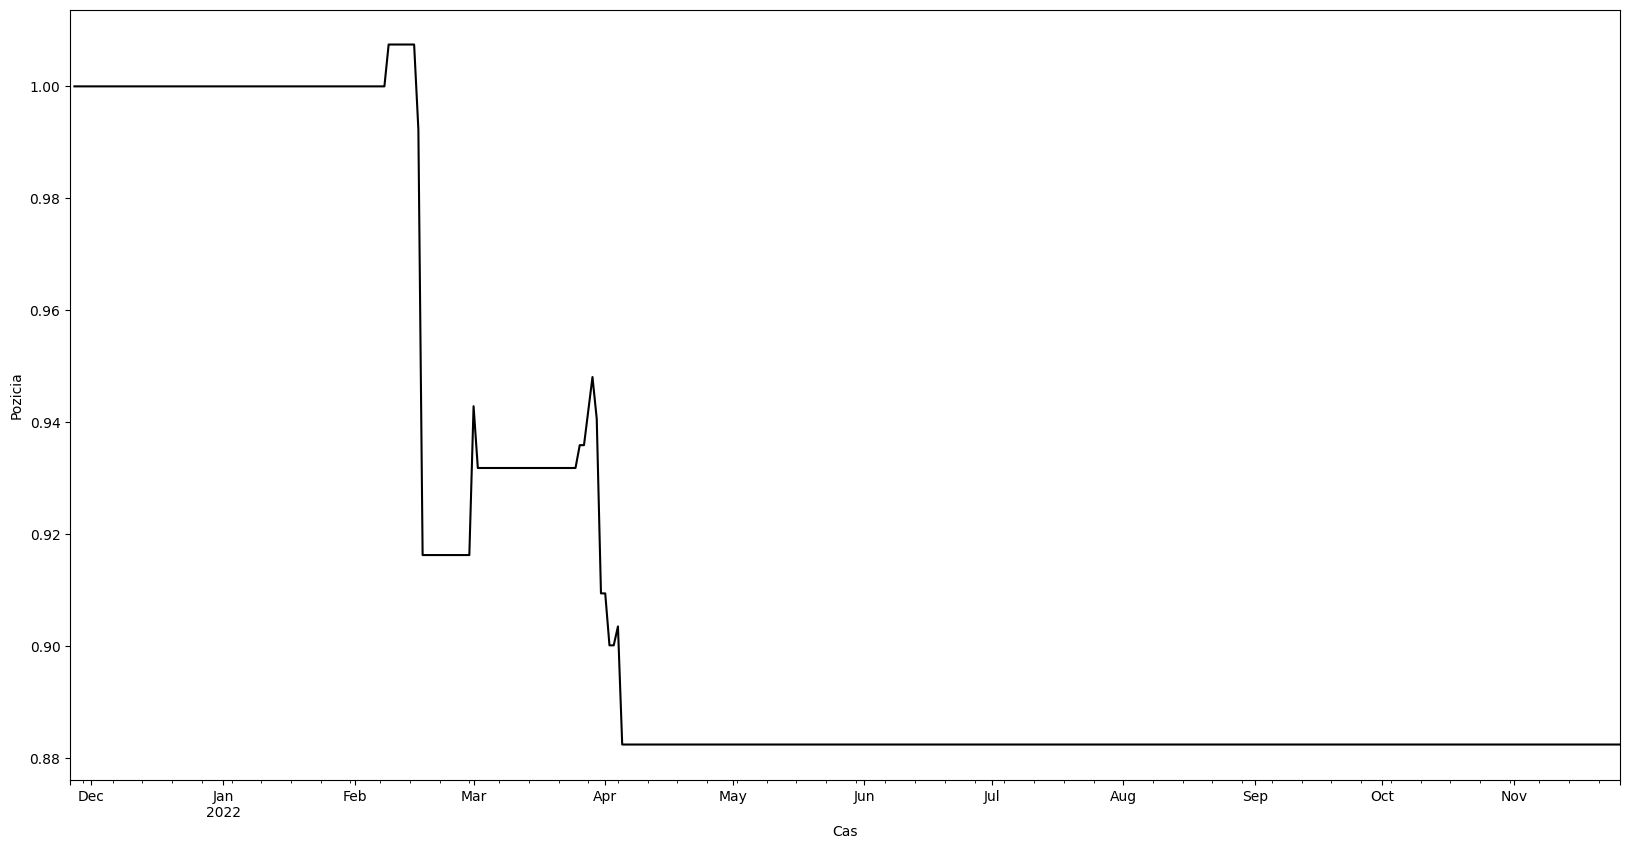

In [52]:
(strategy + 1).cumprod().plot(figsize=(20,10), color ='black')
plt.ylabel('Pozicia')
plt.xlabel('Cas')

**Vidime ze BTC price action je vo vacsine casu bear marketu riadena fear and greed indexom. Investor by sa mohol riadit touto strategiou na maximalizovanie zisku.**

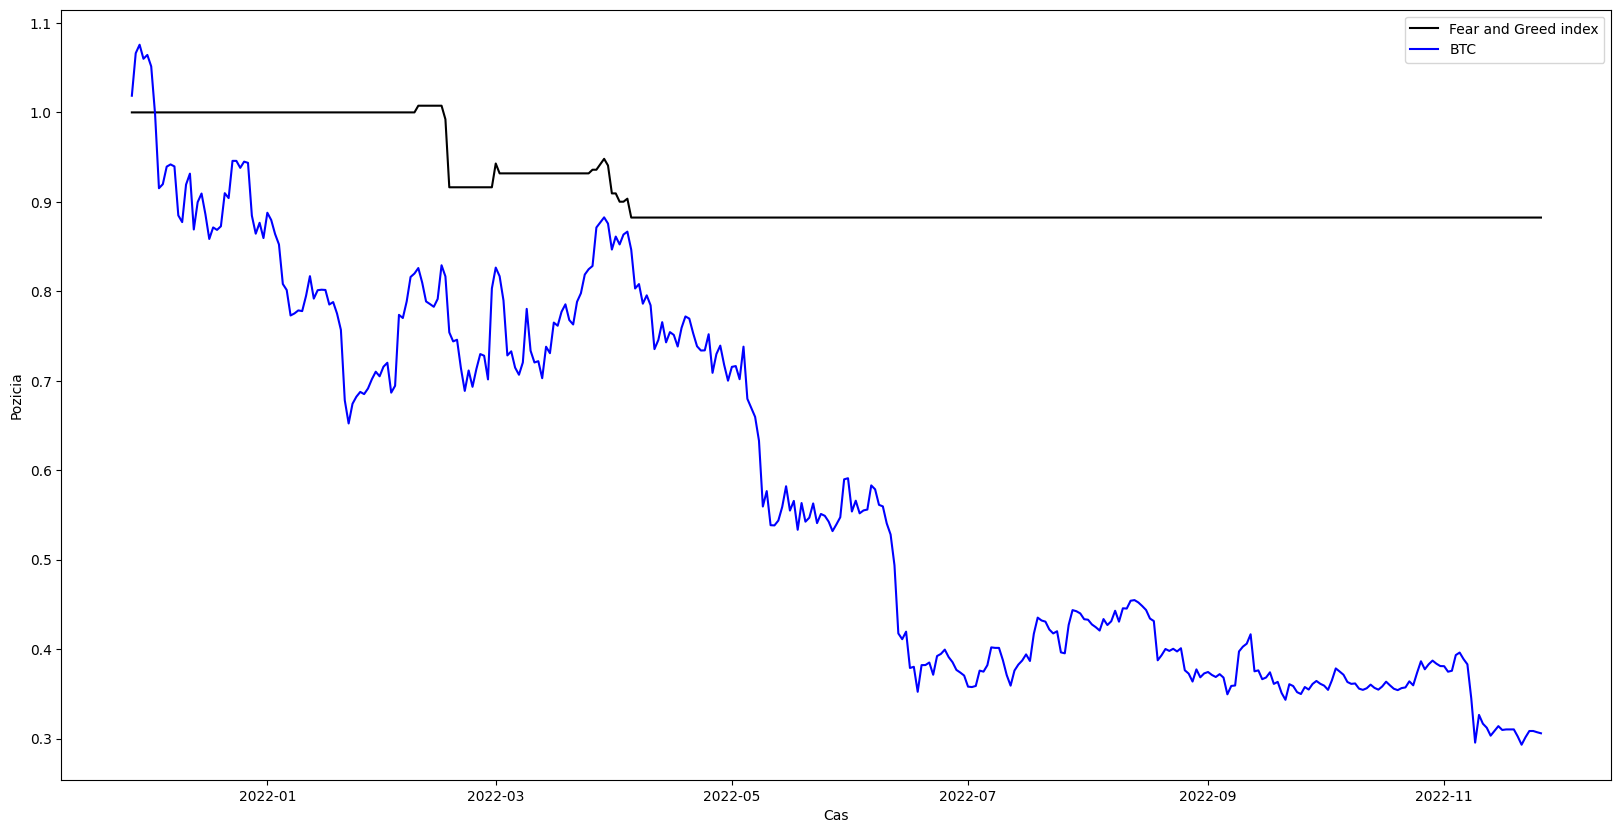

In [53]:
plt.figure(figsize=(20,10))
plt.plot((strategy + 1).cumprod(), label='Fear and Greed index', color = 'black')
plt.plot((new_df_btc.change + 1).cumprod(), label='BTC', color = 'blue')
plt.ylabel('Pozicia')
plt.xlabel('Cas')
plt.legend()

**Fear greed index pre ETH investora.**

In [54]:
df_eth = df_eth.reset_index()
df_eth
df_eth['timestamp']=df_eth['timestamp'].astype('datetime64[ns]')

In [55]:
new_df_eth = df3.merge(df_eth, on=['timestamp'])

In [56]:
new_df_eth = new_df_eth.set_index('timestamp')

In [57]:
new_df_eth

,value,value_classification,Open,High,Low,Close,Volume
timestamp,,,,,,,
2021-11-26,47,Neutral,4527.07,4553.65,3916.18,4044.85,228386.7928
2021-11-27,21,Extreme Fear,4043.67,4185.74,4031.83,4098.02,86395.5469
2021-11-28,27,Fear,4097.88,4301.55,3965.49,4298.14,108556.1541
2021-11-29,33,Fear,4298.15,4463.00,4281.22,4448.42,109285.6020
2021-11-30,40,Fear,4448.41,4756.80,4349.83,4631.81,205269.7430
...,...,...,...,...,...,...,...
2022-11-22,22,Extreme Fear,1106.11,1145.80,1073.84,1138.10,444280.5798
2022-11-23,22,Extreme Fear,1138.25,1189.43,1126.57,1183.31,377272.3006
2022-11-24,20,Extreme Fear,1183.31,1216.88,1180.11,1202.82,282792.2207


In [58]:
new_df_eth['change'] = new_df_eth.Close.pct_change()

In [59]:
new_df_eth

,value,value_classification,Open,High,Low,Close,Volume,change
timestamp,,,,,,,,
2021-11-26,47,Neutral,4527.07,4553.65,3916.18,4044.85,228386.7928,NaN
2021-11-27,21,Extreme Fear,4043.67,4185.74,4031.83,4098.02,86395.5469,0.013145
2021-11-28,27,Fear,4097.88,4301.55,3965.49,4298.14,108556.1541,0.048833
2021-11-29,33,Fear,4298.15,4463.00,4281.22,4448.42,109285.6020,0.034964
2021-11-30,40,Fear,4448.41,4756.80,4349.83,4631.81,205269.7430,0.041226
...,...,...,...,...,...,...,...,...
2022-11-22,22,Extreme Fear,1106.11,1145.80,1073.84,1138.10,444280.5798,0.029061
2022-11-23,22,Extreme Fear,1138.25,1189.43,1126.57,1183.31,377272.3006,0.039724
2022-11-24,20,Extreme Fear,1183.31,1216.88,1180.11,1202.82,282792.2207,0.016488


In [60]:
new_df_eth['position'] = np.where(new_df_eth.value > 50,1,0)

In [61]:
strategy = new_df_eth.position * new_df_eth.change

Text(0.5, 0, 'Cas')

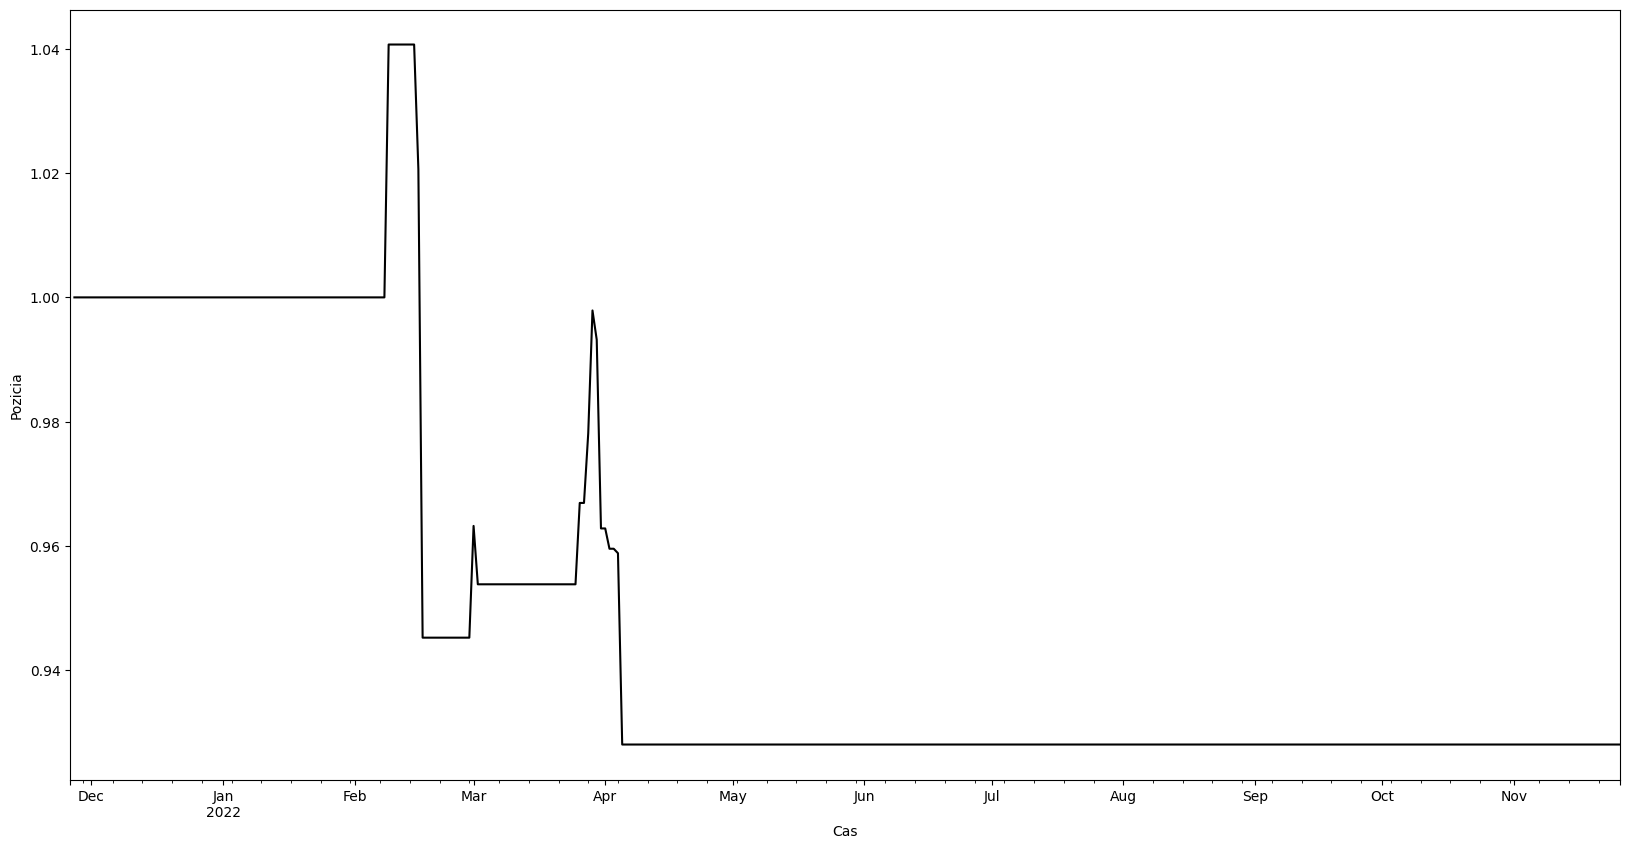

In [62]:
(strategy + 1).cumprod().plot(figsize=(20,10), color ='black')
plt.ylabel('Pozicia')
plt.xlabel('Cas')

**Vidime ze ETH price action je vo vacsine casu bear marketu riadena fear and greed indexom. Investor by sa mohol riadit touto strategiou na maximalizovanie zisku.**

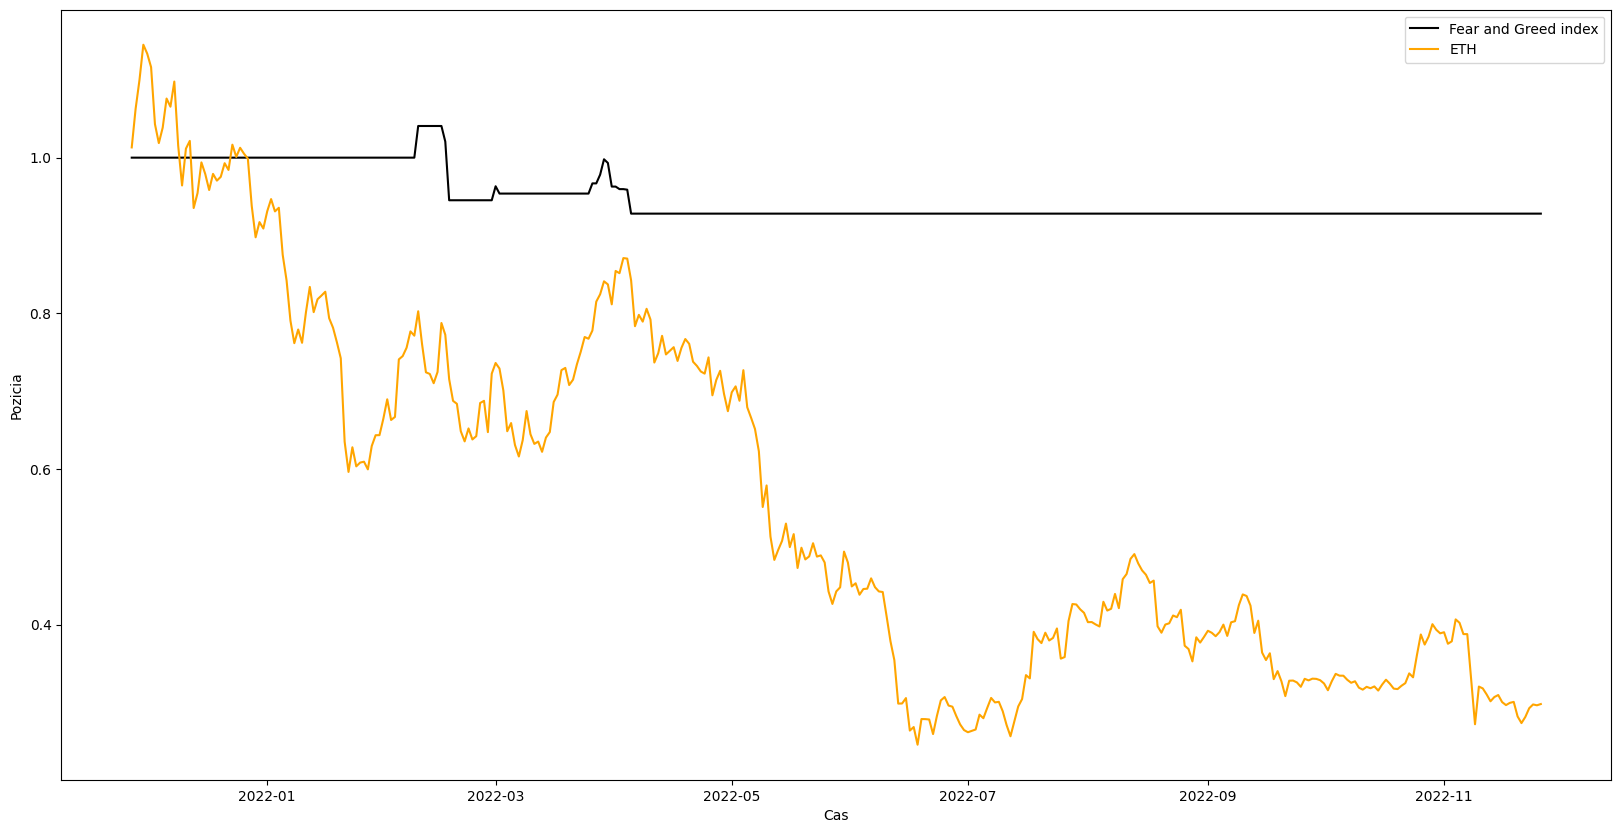

In [63]:
plt.figure(figsize=(20,10))
plt.plot((strategy + 1).cumprod(), label='Fear and Greed index', color = 'black')
plt.plot((new_df_eth.change + 1).cumprod(), label='ETH', color = 'orange')
plt.ylabel('Pozicia')
plt.xlabel('Cas')
plt.legend()

**Ohrozenie validnosti**

**Construct validity: Investor sa nemusi riadit investicnou strategiou a nakupovat zbrklo.**

**Internal validity: Niektore vybrane kryptomeny mozu poskytovat ludom pocit vacsieho bezpecia investovania penazi a preto si ju castokrat volia.**

**External validity: Vybrane kryptomeny nemusia predstavovat typicke spravanie pre price action pocas bear marketu.**

**Zaver**

**Strategia buy and hodl je ucinna pre skorych investorov, skorym nakupom maximalizuju zisky z rastucej uzatvaracej ceny vybranej kryptomeny. H0 sme popreli, pretoze pri zvacsani casoveho rozsahu mozeme vidiet v jednotlivych grafoch to, ze investor je viac greedy v bull markete ako v bear markete. H1 sme potvrdili pretoze existuje rozdiel vo vybere strategie kedy vyberom fear greed strategie by investor pri vybranej kryptomene dosiahol vyssie zisky ako pri buy and hodl strategii.**